In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
df = pd.read_csv('/content/anxiety_depression_data.csv')


In [ ]:
df['Gender'] = df['Gender'].replace({
    'Non-Binary': 'Female',
    'Other': 'Male'
})


In [ ]:
df['Medication_Use'] = df['Medication_Use'].fillna('No').replace('None', 'No')
df['Substance_Use'] = df['Substance_Use'].fillna('No').replace('None', 'No')



In [ ]:
df.isnull().sum()

,0
Age,0
Gender,0
Education_Level,0
Employment_Status,0
Sleep_Hours,0
Physical_Activity_Hrs,0
Social_Support_Score,0
Anxiety_Score,0
Depression_Score,0
Stress_Level,0


<ipython-input-44-e569f36e4647>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Anxiety_Score', data=df, palette='Blues')
<ipython-input-44-e569f36e4647>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Depression_Score', data=df, palette='Reds')


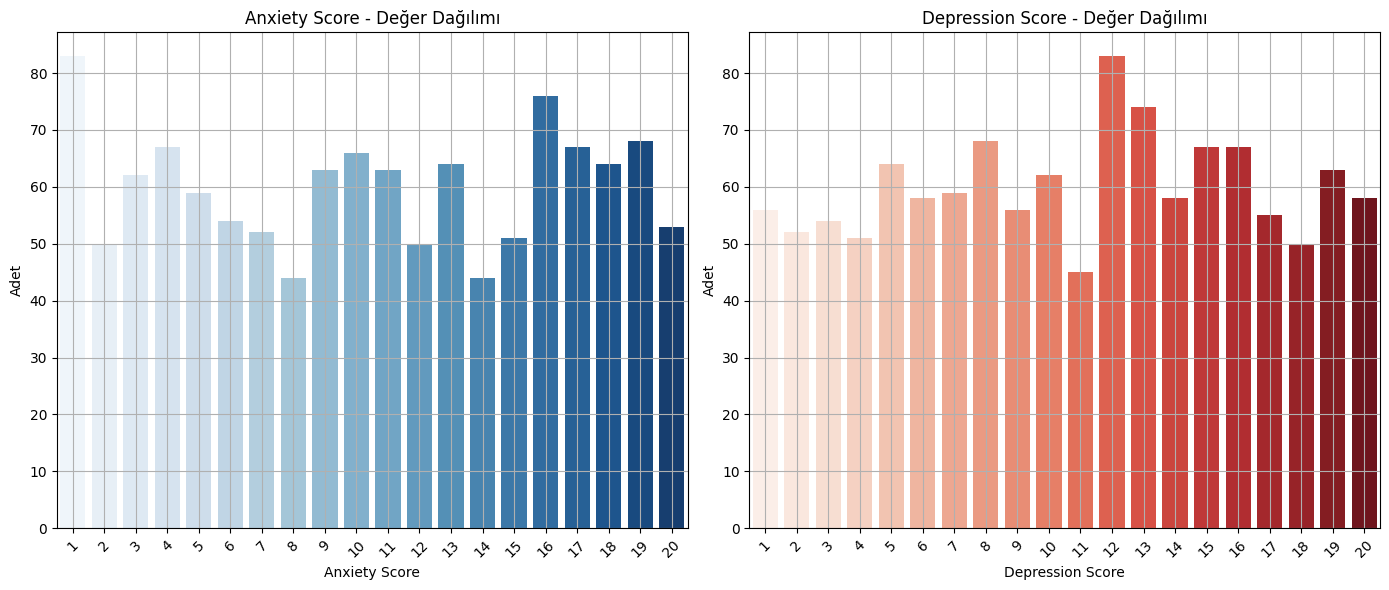

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))

# Anxiety_Score Histogramı
plt.subplot(1, 2, 1)
sns.countplot(x='Anxiety_Score', data=df, palette='Blues')
plt.title('Anxiety Score - Değer Dağılımı')
plt.xlabel('Anxiety Score')
plt.ylabel('Adet')
plt.xticks(rotation=45)
plt.grid(True)

# Depression_Score Histogramı
plt.subplot(1, 2, 2)
sns.countplot(x='Depression_Score', data=df, palette='Reds')
plt.title('Depression Score - Değer Dağılımı')
plt.xlabel('Depression Score')
plt.ylabel('Adet')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
df['Anxiety_Level'] = pd.cut(df['Anxiety_Score'], bins=[0, 6, 11, 16, 21],
                             labels=[0, 1, 2, 3], right=False, include_lowest=True)
# The number of labels is now 3, which is one less than the number of bins (4).

df['Depression_Level'] = pd.cut(df['Depression_Score'], bins=[0, 6, 11, 16, 21],
                                labels=[0, 1, 2, 3], right=False, include_lowest=True)
# The number of labels is now 3, which is one less than the number of bins (4).

In [ ]:
print(df['Anxiety_Level'].value_counts())
print(df['Depression_Level'].value_counts())

Anxiety_Level
3    328
0    321
1    279
2    272
Name: count, dtype: int64
Depression_Level
2    327
1    303
3    293
0    277
Name: count, dtype: int64


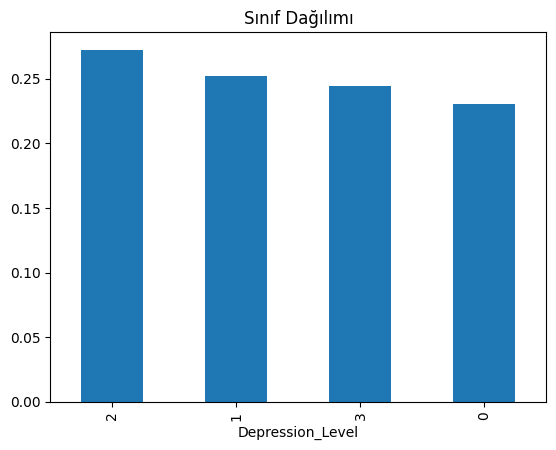

In [ ]:
df['Depression_Level'].value_counts(normalize=True).plot(kind='bar')
plt.title('Sınıf Dağılımı')
plt.show()


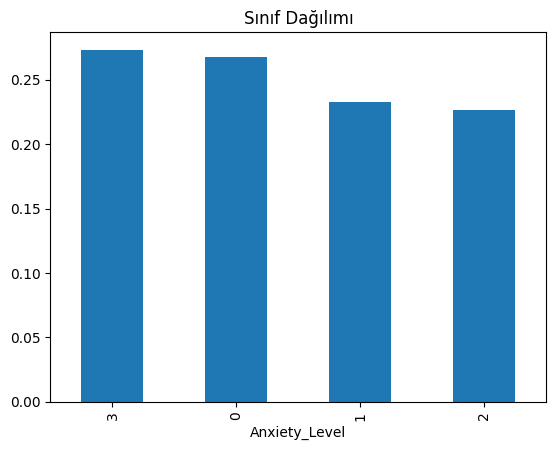

In [ ]:
df['Anxiety_Level'].value_counts(normalize=True).plot(kind='bar')
plt.title('Sınıf Dağılımı')
plt.show()


In [ ]:
# One-hot encoding
categorical_cols = df.select_dtypes(include='object').columns.tolist()
print("Kategorik Sütunlar:", categorical_cols)

categorical_cols.remove('Education_Level')  # Ordinal olarak işlenecek

df = pd.get_dummies(df, columns=categorical_cols)


education_order = ['High School', "Bachelor's", "Master's", 'PhD', 'Other']

# Sütunu sıralı kategorik tipe çevir
df['Education_Level'] = df['Education_Level'].astype(pd.CategoricalDtype(categories=education_order, ordered=True))

# Sayısal kodlara dönüştür
df['Education_Level'] = df['Education_Level'].cat.codes


Kategorik Sütunlar: ['Gender', 'Education_Level', 'Employment_Status', 'Medication_Use', 'Substance_Use']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Age                            1200 non-null   int64   
 1   Education_Level                1200 non-null   int8    
 2   Sleep_Hours                    1200 non-null   float64 
 3   Physical_Activity_Hrs          1200 non-null   float64 
 4   Social_Support_Score           1200 non-null   int64   
 5   Anxiety_Score                  1200 non-null   int64   
 6   Depression_Score               1200 non-null   int64   
 7   Stress_Level                   1200 non-null   int64   
 8   Family_History_Mental_Illness  1200 non-null   int64   
 9   Chronic_Illnesses              1200 non-null   int64   
 10  Therapy                        1200 non-null   int64   
 11  Meditation                     1200 non-null   int64   
 12  Financial_Stress               120

In [ ]:
df['Anxiety_Level'] = df['Anxiety_Level'].astype(int)
df['Depression_Level'] = df['Depression_Level'].astype(int)


In [ ]:
for col in df.select_dtypes(include='bool').columns:
    df[col] = df[col].astype(int)


In [ ]:
for col in df.select_dtypes(include='float').columns:
    df[col] = df[col].astype(int)


In [ ]:
 Hedef ve özellikleri belirle
X = df.drop(columns=['Anxiety_Score', 'Depression_Score', 'Anxiety_Level', 'Depression_Level'])
y = df['Anxiety_Level'].astype(int)

# Random Forest ile eğitim
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Özellik önemlerini DataFrame olarak sırala
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)

# Görselleştir
plt.figure(figsize=(12, 6))
feature_importance.plot(kind='bar')
plt.title('Anxiety Prediction - Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   Age                            1200 non-null   int64
 1   Education_Level                1200 non-null   int8 
 2   Sleep_Hours                    1200 non-null   int64
 3   Physical_Activity_Hrs          1200 non-null   int64
 4   Social_Support_Score           1200 non-null   int64
 5   Anxiety_Score                  1200 non-null   int64
 6   Depression_Score               1200 non-null   int64
 7   Stress_Level                   1200 non-null   int64
 8   Family_History_Mental_Illness  1200 non-null   int64
 9   Chronic_Illnesses              1200 non-null   int64
 10  Therapy                        1200 non-null   int64
 11  Meditation                     1200 non-null   int64
 12  Financial_Stress               1200 non-null   int64
 13  Work_Stress       

In [ ]:

X = df.drop(columns=['Anxiety_Score', 'Depression_Score', 'Anxiety_Level','Depression_Level'])
y = df['Anxiety_Level'].astype(int)

# 📏 Ölçekleme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)




# 🔀 Eğitim/test ayırımı
# Veriyi train, val, test olarak böl
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)


In [ ]:
# Etiketleri one-hot vektörlere dönüştür (sınıflandırma için)
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [ ]:
# One-hot encoding
df = pd.get_dummies(df, columns=categorical_cols)

In [ ]:
# Doğru sıralamayı tanımla
education_order = ['High School', "Bachelor's", "Master's", 'PhD', 'Other']

# Sütunu sıralı kategorik tipe çevir
df['Education_Level'] = df['Education_Level'].astype(pd.CategoricalDtype(categories=education_order, ordered=True))

# Sayısal kodlara dönüştür
df['Education_Level'] = df['Education_Level'].cat.codes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            1200 non-null   int64  
 1   Education_Level                1200 non-null   int8   
 2   Sleep_Hours                    1200 non-null   float64
 3   Physical_Activity_Hrs          1200 non-null   float64
 4   Social_Support_Score           1200 non-null   int64  
 5   Anxiety_Score                  1200 non-null   int64  
 6   Depression_Score               1200 non-null   int64  
 7   Stress_Level                   1200 non-null   int64  
 8   Family_History_Mental_Illness  1200 non-null   int64  
 9   Chronic_Illnesses              1200 non-null   int64  
 10  Therapy                        1200 non-null   int64  
 11  Meditation                     1200 non-null   int64  
 12  Financial_Stress               1200 non-null   i

In [ ]:
X = df.drop(columns=['Anxiety_Score', 'Depression_Score'])
y = df['Anxiety_Score']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



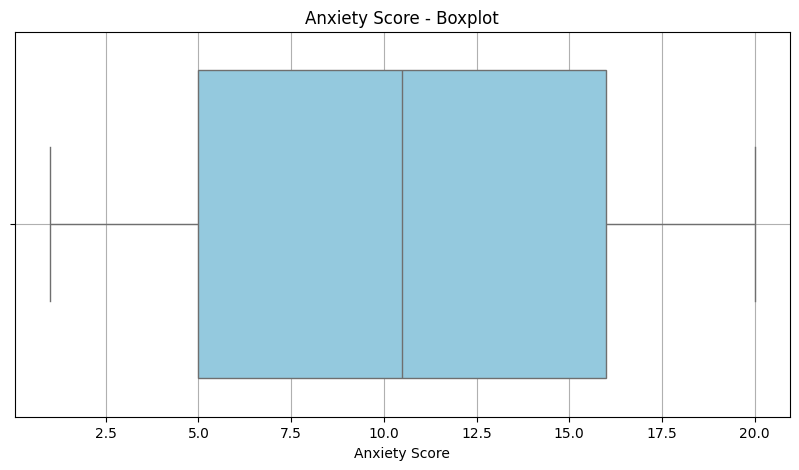

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Anxiety_Score'], color='skyblue')
plt.title("Anxiety Score - Boxplot")
plt.xlabel("Anxiety Score")
plt.grid(True)
plt.show()


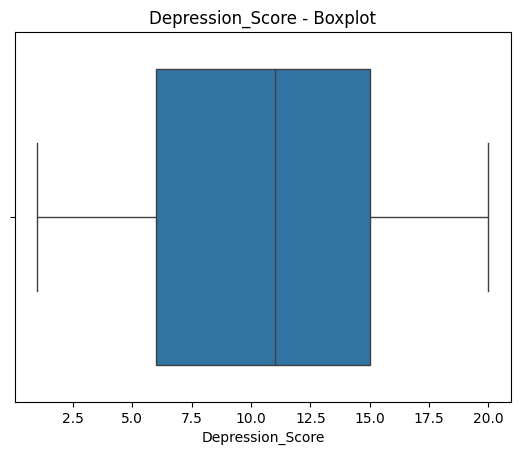

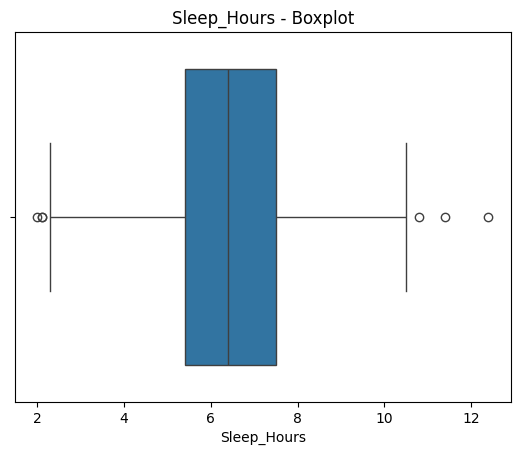

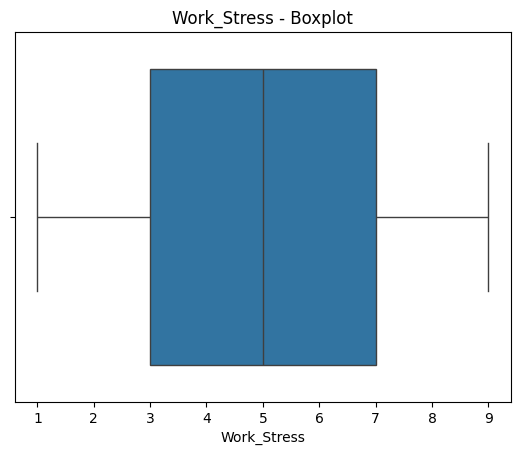

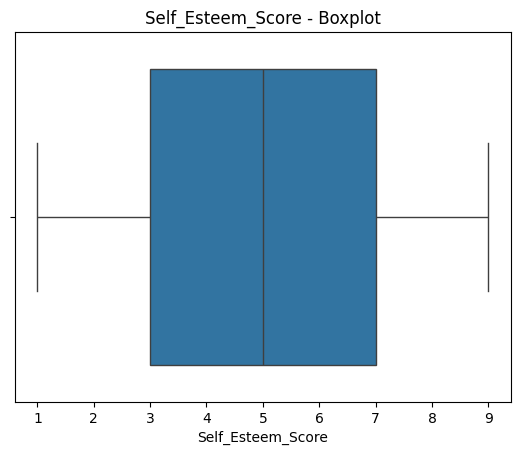

In [ ]:
for col in ['Depression_Score', 'Sleep_Hours', 'Work_Stress', 'Self_Esteem_Score']:
    sns.boxplot(x=df[col])
    plt.title(f"{col} - Boxplot")
    plt.show()


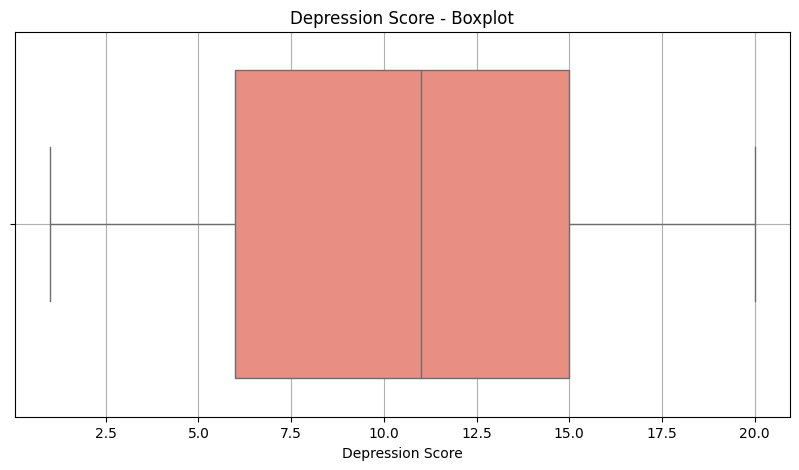

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Depression_Score'], color='salmon')
plt.title("Depression Score - Boxplot")
plt.xlabel("Depression Score")
plt.grid(True)
plt.show()


In [ ]:
Q1 = df['Depression_Score'].quantile(0.25)
Q3 = df['Depression_Score'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Depression_Score'] < lower_bound) | (df['Depression_Score'] > upper_bound)]

print(f"Aykırı değer sayısı: {len(outliers)}")
print(outliers[['Depression_Score']])


Aykırı değer sayısı: 0
Empty DataFrame
Columns: [Depression_Score]
Index: []


In [ ]:
from xgboost import XGBClassifier

In [ ]:
# --- GİRİŞ / ÇIKIŞ ---
X = df.drop(columns=['Anxiety_Score', 'Depression_Score', 'Anxiety_Level', 'Depression_Level'])
y = to_categorical(df['Anxiety_Level'].astype(int))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softmax',
    num_class=4,
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    early_stopping_rounds=10,
    verbosity=0
)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
xgb_preds = xgb_model.predict(X_test)

print("\n" + "="*50)
print("XGBoost Performansı:")
print("="*50)
print(classification_report(y_test, xgb_preds))

In [ ]:
#keras
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model = Sequential([
    Dense(256, activation='swish', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='swish', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='leaky_relu'),
    Dense(4, activation='softmax')
])

model.compile(
    optimizer=Nadam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


In [ ]:
keras_preds = np.argmax(model.predict(X_test), axis=1)
print("\n" + "="*50)
print("Keras Performansı:")
print("="*50)
print(classification_report(y_test, keras_preds))

from sklearn.metrics import accuracy_score, classification_report

xgb_preds = xgb_model.predict(X_test)

print("\n" + "="*50)
print("XGBoost Performansı:")
print("="*50)
print("Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))


In [ ]:
plt.figure(figsize=(12, 6))

# Accuracy Grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy', pad=20)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss', pad=20)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()